# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [1]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.

import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [2]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

11490434/11490434 [==============================] - 2s 0us/step
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [3]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 4


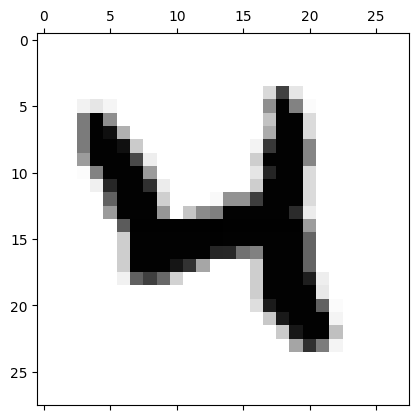

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [4]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [6]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [7]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 0.7581 - acc: 0.7766 - val_loss: 0.3118 - val_acc: 0.9146
Epoch 2/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.3834 - acc: 0.8913 - val_loss: 0.2377 - val_acc: 0.9328
Epoch 3/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3072 - acc: 0.9130 - val_loss: 0.2023 - val_acc: 0.9393
Epoch 4/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2630 - acc: 0.9259 - val_loss: 0.1745 - val_acc: 0.9478
Epoch 5/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.2336 - acc: 0.9337 - val_loss: 0.1583 - val_acc: 0.9532


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

313/313 [==============================] - 1s 4ms/step - loss: 0.1583 - acc: 0.9532

Test loss: 0.15825271606445312
Test accuracy: 0.9531999826431274


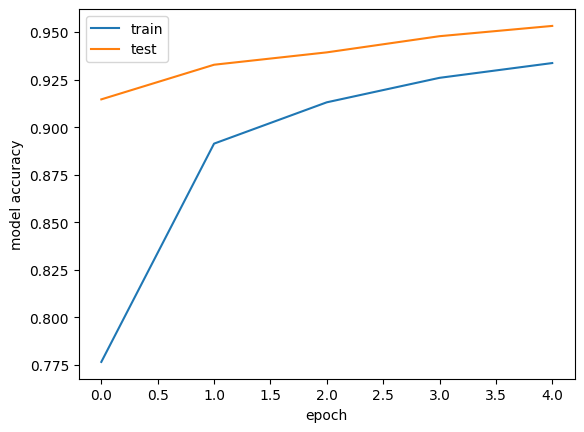

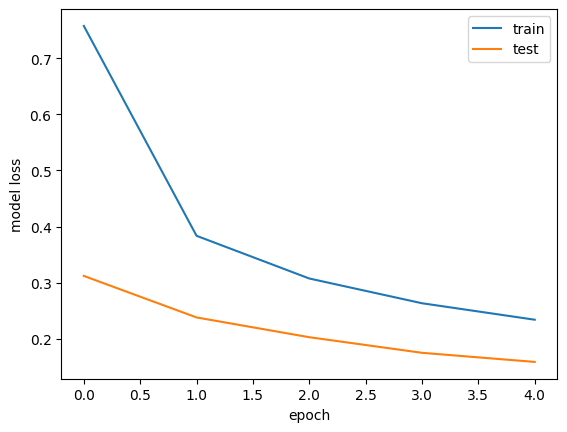

In [8]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 [==============================] - 1s 4ms/step


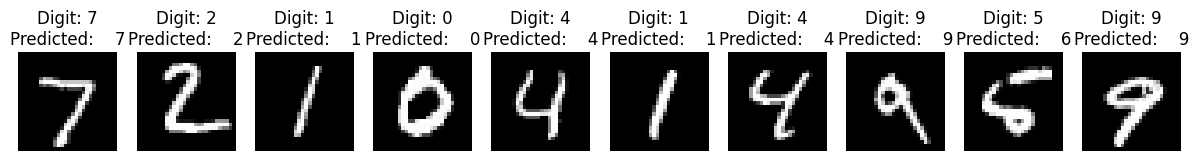

In [9]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

---

Si testano ora le prestazioni di una Deep Neural Network variando il solo ottimizzatore. In questo caso si utilizza prima di tutto il Stocastic Gradient Descent (SGD), dopodichè si utilizzano gli ottimizzatori Adam e Adagrad. Per ciascuno di questi si studia l'andamento di loss e accuracy.

Dunque inizialmente i dati vengono convertiti in vettori 10-dimensionali in cui l'unica componente non azzerata è quella corrispondente alla cifra associata all'immagine.
Negli hidden layers della rete è stata scelta come funzione di attivazione la ReLu e per il layer di output la SoftMax. Quest'ultima è stata scelta poichè in grado di generare un risultato finale sotto forma di una serie di probabilità, una per ognuna delle categorie possibili. In questo modo la casella contenente la probabilità più alta corrisponde alla cifra associata dalla rete all'immagine analizzata.

Dunque la rete neurale che si costruisce è determinata da tanti neuroni di input quanti sono i pixel che determinano la figura che si vuole riconoscere, dopodichè si ha un hidden layer di 100 neuroni con funzione di attivazione ReLu, quindi viene aggiunto un layer di Dropout con rate 0.5. Questo è un metodo per regolarizzare la rete neurale e prevenire l'overfitting. Imposta casualmente a zero una frazione (in questo caso il $50\%$) delle uscite dei neuroni del layer precedente durante l'addestramento, il che aiuta a prevenire la dipendenza troppo forte tra i neuroni. Viene dunque aggiunto un ultimo layer con 10 neuroni, corrispondenti ai numeri che vanno da 0 a 9, ovvero il numero di classi di output. L'attivazione utilizzata in questo layer, come è stato detto precedentemente, è la funzione softmax, che restituisce la probabilità di appartenenza ad ogni classe.

Si considerano 10 epoche per ogni rete neurale.

In [20]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [37]:
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

img_rows, img_cols = 28, 28 
num_classes = 10  

# Dati separati in training e test
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Creo le immagini di test in forma vettoriale (1000,256): 
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# Lancio i float a singola precisione:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Riscalo dei dati nell'intervallo [0,1]
X_train /= 255
X_test /= 255

# Voglio che l'identificazione dell'immagine "numero" sia codificata in un vettore di 0 e 1.
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

In [38]:
# Creo l'architettura della Deep Neural Network
def create_DNN():
    model = Sequential()
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Creazione del modello e compilazione
# Ottimizzatore Stochastic Gradient Descend
def compile_model_sgd():
    model=create_DNN()   
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=SGD(),metrics=['accuracy'])
    return model

# Ottimizzatore Adam
def compile_model_adam():
    model=create_DNN()   
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=Adam(),metrics=['accuracy'])
    return model

# Ottimizzatore Adagrad
def compile_model_adagrad():
    model=create_DNN()   
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=Adagrad(),metrics=['accuracy'])
    return model

---

### Ottimizzatore Stochastic Gradient Descend

In [39]:
# Training della rete DNN con ottimizzatore SGD
model_DNN_sgd = compile_model_sgd()
h_sgd = model_DNN_sgd.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=0, validation_data=(X_test, Y_test))

Test loss: 0.1072455570101738
Test accuracy: 0.9663000106811523


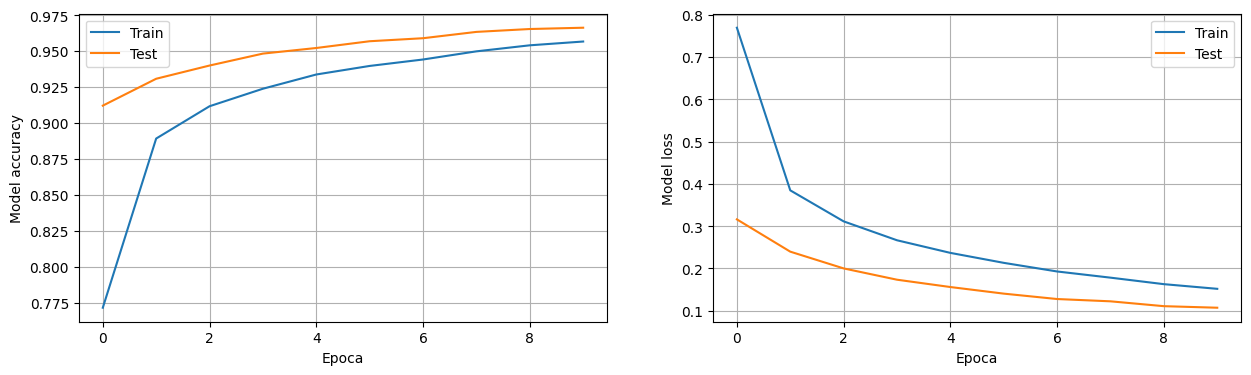

In [40]:
score = model_DNN_sgd.evaluate(X_test, Y_test, verbose=0)  
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(h_sgd.history['accuracy'])
plt.plot(h_sgd.history['val_accuracy'])
plt.ylabel('Model accuracy')
plt.xlabel('Epoca')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(h_sgd.history['loss'])
plt.plot(h_sgd.history['val_loss'])
plt.ylabel('Model loss')
plt.xlabel('Epoca')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.show()

Si osserva che nel caso dell'ottimizzatore Stochastic Gradient Descend, la Loss Function decresce costantemente aumentando il numero di epoche sia per il training set che per il validation set, da cui si può constatare che il modello non è soggetto ad overfitting. Esso può essere quindi migliorato ulteriormente aumentando il numero di epoche.

Il fatto che la loss function sia minimizzata in modo più eclatante nel caso del validation set è dovuto probabilmente all'utilizzo del layer di dropout. Questo infatti spegne alcuni neuroni solo in fase di training.

313/313 [==============================] - 2s 7ms/step


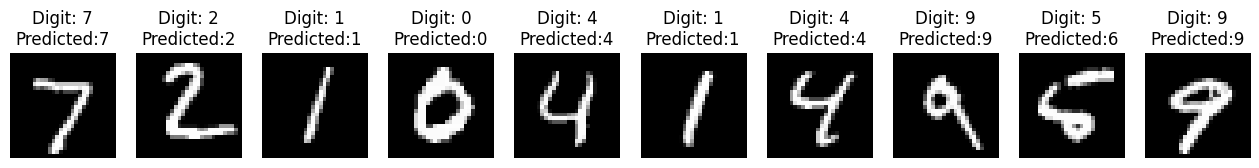

In [41]:
predictions = model_DNN_sgd.predict(X_test)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(16, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

---

### Ottimizzatore Adam

In [28]:
# Separo i dati in training e test
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Imposto le immagini di test in forma matriciale 28x28:
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# Lancio i float a singola precisione:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Riscalo dei dati nell'intervallo [0,1]
X_train /= 255
X_test /= 255

# Voglio che l'identificazione dell'immagine "numero" sia codificata in un vettore di 0 e 1.
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

In [29]:
# Training della rete DNN con ottimizzatore Adam
model_DNN_adam = compile_model_adam()
h_adam = model_DNN_adam.fit(X_train, Y_train, batch_size=32, epochs=10,verbose=0, validation_data=(X_test, Y_test))

Test loss: 0.11336016654968262
Test accuracy: 0.9779999852180481


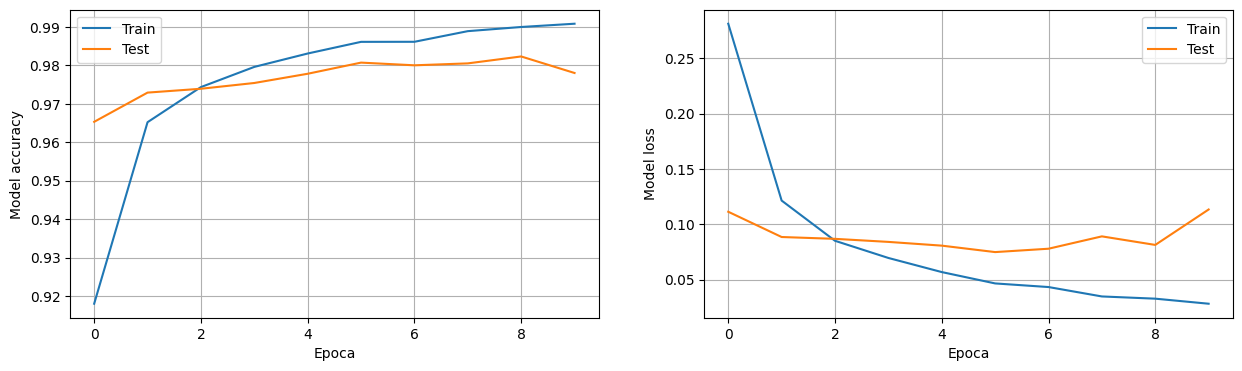

In [31]:
score = model_DNN_adam.evaluate(X_test, Y_test, verbose=0)  
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(h_adam.history['accuracy'])
plt.plot(h_adam.history['val_accuracy'])
plt.ylabel('Model accuracy')
plt.xlabel('Epoca')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(h_adam.history['loss'])
plt.plot(h_adam.history['val_loss'])
plt.ylabel('Model loss')
plt.xlabel('Epoca')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.show()

Si osserva che, nel caso in cui viene utilizzato come ottimizzatore Adam, da un certo punto (circa per 4 epoche) all'aumentare delle epoche la loss function associata al validation set aumenta, e la distanza tra la loss di training e la loss di validazione cresce. Per questo motivo potremmo ipotizzare che la rete è soggetta ad un overfitting dei dati.

313/313 [==============================] - 1s 4ms/step


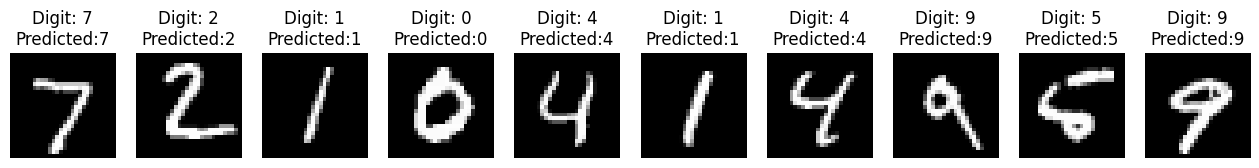

In [32]:
predictions = model_DNN_adam.predict(X_test)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(16, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

---

### Ottimizzatore Adagrad

In [42]:
# Separo i dati in training e test
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Imposto le immagini di test in forma matriciale 28x28:
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# Lancio i float a singola precisione:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Riscalo dei dati nell'intervallo [0,1]
X_train /= 255
X_test /= 255

# Voglio che l'identificazione dell'immagine "numero" sia codificata in un vettore di 0 e 1.
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

In [43]:
# Training della rete DNN con ottimizzatore Adagrad
model_DNN_adagrad = compile_model_adagrad()
h_adagrad = model_DNN_adagrad.fit(X_train,Y_train,batch_size=32,epochs=10,verbose=0,validation_data=(X_test, Y_test))

Test loss: 0.26566383242607117
Test accuracy: 0.9276000261306763


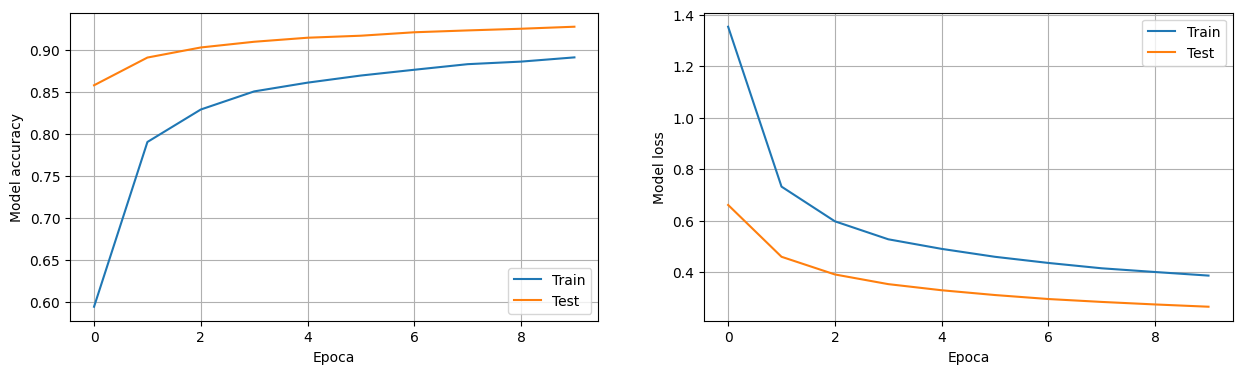

In [44]:
score = model_DNN_adagrad.evaluate(X_test, Y_test, verbose=0)  
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(h_adagrad.history['accuracy'])
plt.plot(h_adagrad.history['val_accuracy'])
plt.ylabel('Model accuracy')
plt.xlabel('Epoca')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(h_adagrad.history['loss'])
plt.plot(h_adagrad.history['val_loss'])
plt.ylabel('Model loss')
plt.xlabel('Epoca')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.show()

Si osserva che nel caso in cui viene utilizzato come ottimizzatore Adagrad, i risultati sono molto simili a quelli ottenuti con lo Stochastic Gradient Descent, perciò si può considerare il modello costruito come un buon modello.

Comunque sia, essendo che la loss function è minimizzata nel caso in cui si utilizza come ottimizzatore lo SGD, lo si utilizzerà come ottimizzatore di default in seguito.

313/313 [==============================] - 1s 4ms/step


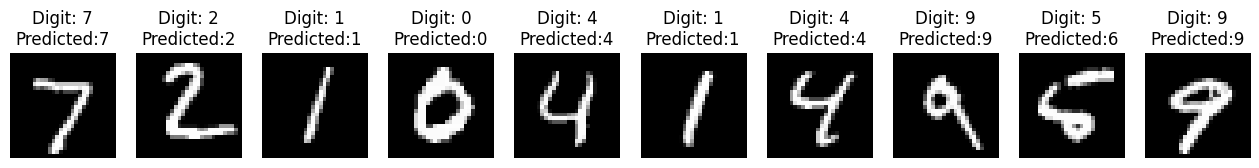

In [36]:
predictions = model_DNN_adagrad.predict(X_test)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(16, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

---

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

---

Ora verrà implementata una Convolutional Neural Network, dotata quindi di layer di convoluzione, che consistono in un insieme di filtri convolutivi che scansionano l'immagine di input per estrarre caratteristiche rilevanti.

In questo caso viene aggiunto un layer Conv2D con 10 filtri, ciascuno di dimensione 5x5, dove la forma dell'input che questo primo layer riceverà è determinata da input_shape, e la funzione di attivazione utilizzata in questo layer è la funzione ReLU. Dopodichè viene aggiunto un layer MaxPooling2D con pool size 3x3: questo riduce la dimensione dell'output utilizzando la tecnica di max pooling, che seleziona il valore massimo all'interno di una finestra rettangolare. Dunque vengono aggiunti altri due layer Conv2D e MaxPooling2D, e un layer Flatten per appiattire l'output in un vettore unidimensionale, in modo che possa essere collegato al layer denso successivo di 10 neuroni, con funzione di attivazione softmax.

Prima di tutto però, bisogna adattare la forma dei dati di input all'architettura della rete neurale, infatti Keras può supportare due formati: "channels_first" e "channels_last". Se il formato dei dati di immagine è "channels_first", significa che il canale del colore dell'immagine è il primo asse dei dati. In questo caso, i dati del training set e del validation set vengono ridimensionati utilizzando il metodo reshape() per avere la forma *(numero di campioni in input per l'addestramento, numero_di_canali, righe, colonne)*, altrimenti vengono vengono riscalati sempre con lo stesso metodo per avere la forma *(numero_di_esempi, righe, colonne, numero_di_canali)*. Ol numero di canali è 1 e si riferisce alla scala di grigi.

In [45]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [46]:
def create_CNN():
    model = Sequential()
    model.add(Conv2D(10, kernel_size=(5, 5), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='SGD',metrics=['accuracy'])
    return model

In [47]:
model_CNN=create_CNN()
model_CNN.fit(X_train, Y_train,batch_size=32,epochs=10,verbose=1,validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.8121 - accuracy: 0.7620 - val_loss: 0.2189 - val_accuracy: 0.9436
Epoch 2/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2424 - accuracy: 0.9327 - val_loss: 0.1325 - val_accuracy: 0.9619
Epoch 3/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.1735 - accuracy: 0.9518 - val_loss: 0.0975 - val_accuracy: 0.9702
Epoch 4/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1424 - accuracy: 0.9598 - val_loss: 0.0803 - val_accuracy: 0.9755
Epoch 5/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1232 - accuracy: 0.9643 - val_loss: 0.0702 - val_accuracy: 0.9790
Epoch 6/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1108 - accuracy: 0.9668 - val_loss: 0.0612 - val_accuracy: 0.9809
Epoch 7/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0984 - accuracy: 0.9718 - val_loss: 0.0559 -

Test loss: 0.0451388843357563
Test accuracy: 0.9854000210762024


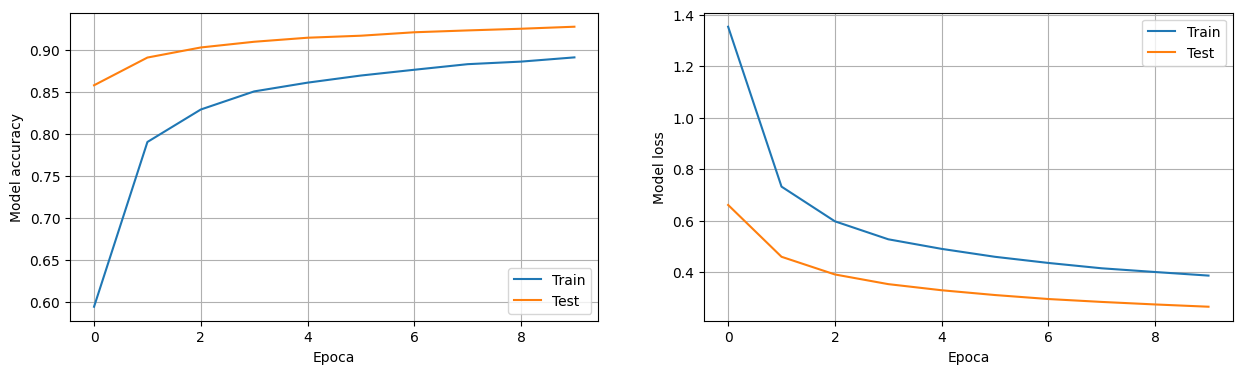

In [48]:
score = model_CNN.evaluate(X_test, Y_test, verbose=0)  
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(h_adagrad.history['accuracy'])
plt.plot(h_adagrad.history['val_accuracy'])
plt.ylabel('Model accuracy')
plt.xlabel('Epoca')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(h_adagrad.history['loss'])
plt.plot(h_adagrad.history['val_loss'])
plt.ylabel('Model loss')
plt.xlabel('Epoca')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.show()

Come nel caso della Deep Neural Network con ottimizzatore SGD, la Convolutional Neural Network presenta una loss di validazione sempre inferiore a quella di training. Tuttavia la loss function sul validation set in questo caso, dopo 10 epoche di addetsramento, è decisamente minore di quella della Deep Neural Network. Dunque si può constatare che il modello costruito tramite questa rete neurale sia di gran lunga migliore.

---

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

---

Utilizzando l'applicazione `gimp`, creo 10 immagini di cifre scritte a mano al fine di testare su questo nuovo dataset le reti neurali CNN e DNN rispettivamente.

1/1 [==============================] - 0s 40ms/step


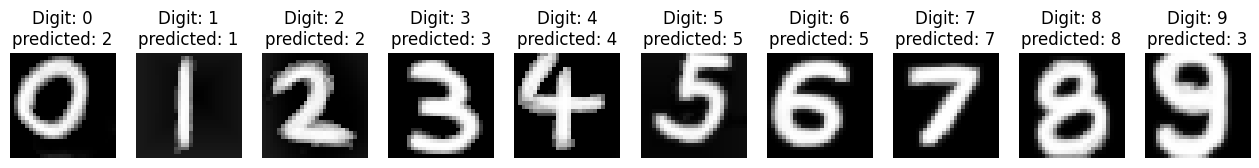

In [52]:
# Carico i dati, li riorganizzo, e faccio agire la Convolutional Neural Network precedente
from PIL import Image

plt.figure(figsize=(16, 3))  
for i in range(0,10,1):
    digit_filename = 'Immagini/'+str(i)+'.png'
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    px=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for k in range(xdim):
            data[k,j]=px[j,k]
    data /= 255
    data = data.reshape(1,xdim,ydim,1)
    pred_0 = model_CNN.predict(data)
    data = data.reshape(xdim,ydim)

    plt.subplot(1,10,i+1)
    plt.imshow(data, cmap='gray')    
    plt.title("Digit: "+str(i)+"\npredicted: {}".format(np.argmax(pred_0)))
    plt.axis('off') 
plt.show()

1/1 [==============================] - 0s 39ms/step


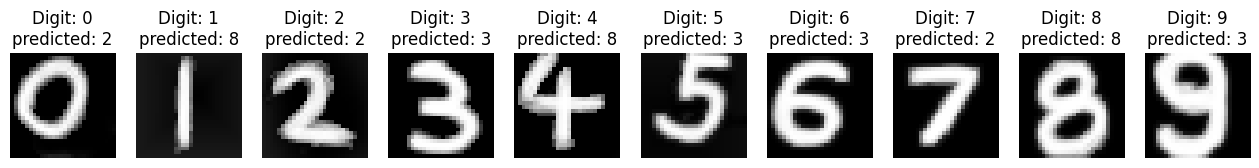

In [54]:
for i in range(10):
    digit_filename = 'Immagini/'+str(i)+'.png'
    digit_in = Image.open(digit_filename).convert('L')  
    if i==0:
        ydim, xdim = digit_in.size
        data = np.zeros((10,xdim, ydim))
    pix=digit_in.load();
    for k in range(ydim):
        for j in range(xdim):
            data[i,j,k]=pix[k,j]
data /= 255
data = data.reshape(10,xdim*ydim)
predictions = model_DNN_sgd.predict(data)
data = data.reshape(10,xdim,ydim)

plt.figure(figsize=(16, 3)) 
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(data[i], cmap='gray')    
    plt.title("Digit: "+str(i)+"\npredicted: {}".format(np.argmax(predictions[i])))
    plt.axis('off') 
plt.show()

Come possiamo notare dai risultati ottenuti sul dataset nuovo, le prestazioni in termini di potere predittivo della rete sono a favore della Convolutional Neural Network.

---

### <span style="color:green">Supplementary information 1: Use of `gimp` </span>

- from the Unix shell type: `gimp` and hit `Return`
- File -> new (chose: 28x28 pixels)
- rascale the image to 800%
- Use the **brush** with dimension 2px to draw your digit
- Color -> invert (to have black background)
- Export the image as a `.png` file

That's all!

### <span style="color:green">Supplementary information 2: Display trained filters in your CNN</span>

Print your NN layers:

In [ ]:
layer_index=0
for layer in model_CNN.layers:
    print(layer_index, layer.name)
    layer_index+=1

Display your filters:

In [ ]:
# layer_index should be the index of a convolutional layer
layer_index=0
# retrieve weights from the convolutional hidden layer
filters, biases = model_CNN.layers[layer_index].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters.shape)

# plot filters
n_filters, ix = filters.shape[3], 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # specify subplot and turn of axis
    ax = plt.subplot(1,n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
# show the figure
plt.show()

### <span style="color:green">Supplementary information 3: Monitor layer outputs in your CNN</span>

In [ ]:
test_index = 0

from keras.models import Model
layer_outputs = [layer.output for layer in model_CNN.layers]
activation_model = Model(inputs=model_CNN.input, outputs=layer_outputs)
activations = activation_model.predict(X_test[test_index].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, layer_index): 
    activation = activations[layer_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3,col_size*3))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [ ]:
%matplotlib inline
plt.imshow(X_test[test_index][:,:,0], cmap='gray')
# def display_activation(activations, col_size, row_size, layer number)
display_activation(activations, 4, 2, 0)
# col_size x row_size must be <= Number of filters for the convolutional layer